# Build Your Own Wflow Hydrological Model

## Overview

This interactive notebook allows you to build a custom **Wflow hydrological model** for any location in East Africa. Using an interactive map, you can select your catchment outlet point, configure model parameters, and generate a complete hydrological model ready for simulation.

### What You'll Do

1. **Select your catchment outlet** using an interactive map
2. **Configure model parameters** including forcing data and grid resolution
3. **Build your model** automatically using HydroMT
4. **Visualize the results** to verify your model setup

---

## Prerequisites

Before starting, ensure you have:
- Completed the training notebook (2_DireDawa_hydrological_model_training.ipynb)
- Selected the **"HydroMT wflow (pixi)"** kernel (top-right corner)
- Prepared your data catalogs and configuration files

---

## Important Note

This notebook uses **interactive widgets** and an **interactive map**. Make sure to:
- Run cells sequentially from top to bottom
- Wait for each cell to complete before running the next one
- Save your work frequently

In [1]:
# Standard library imports
import os
import json
from pathlib import Path
from datetime import datetime

# Data manipulation
import numpy as np
import pandas as pd
import xarray as xr
import pandas as pd

# Geospatial libraries
import geopandas as gpd
from shapely.geometry import Point

# Visualization
import matplotlib.pyplot as plt
import folium
from folium import plugins

# TOML parsing
# import toml

# IPython widgets for interactivity
from ipywidgets import widgets, Layout
from IPython.display import display, HTML, clear_output

print("✓ All imports successful!")

ModuleNotFoundError: No module named 'ipywidgets'


## Part 1: Interactive Map for Outlet Selection

### Create Interactive Map

Use this interactive map to:
- **Visualize** reference layers (hydrosheds05, hydrosheds06)
- **Click** anywhere to select your catchment outlet point
- **View** the coordinates of your selected point

The map will display your click coordinates in latitude and longitude.

In [ ]:
# Set hydroSHEDS geojson files
GEOJSON_FILES = {
    "hydrobasins_level05": "/data/shared/hydroMT_data/hydromt_east_africa/hydrobasins_level05.geojson",
    "hydrobasins_level06": "/data/shared/hydroMT_data/hydromt_east_africa/hydrobasins_level06.geojson",
}

# Initialize coordinate storage
selected_coords = {'lat': None, 'lon': None}

def create_interactive_map(center=[9.5, 41.0], zoom=7, geojson_files=None):
    """
    Create an interactive Folium map with click functionality.
    
    Parameters:
    -----------
    center : list
        [latitude, longitude] for map center (default: Dire Dawa region)
    zoom : int
        Initial zoom level
    geojson_files : dict
        Dictionary of {layer_name: file_path} for GeoJSON layers
    
    Returns:
    --------
    folium.Map
        Interactive map object
    """
    # Create base map
    m = folium.Map(
        location=center,
        zoom_start=zoom,
        tiles='OpenStreetMap',
        control_scale=True
    )
    
    # # Add alternative base layers
    # folium.TileLayer(
    #     tiles='https://{s}.tile.opentopomap.org/{z}/{x}/{y}.png',
    #     attr='Map data: &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, <a href="http://viewfinderpanoramas.org">SRTM</a> | Map style: &copy; <a href="https://opentopomap.org">OpenTopoMap</a>',
    #     name='Terrain'
    # ).add_to(m)
    
    # folium.TileLayer(
    #     tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    #     attr='Esri',
    #     name='Satellite',
    #     overlay=False,
    #     control=True
    # ).add_to(m)
    
    # Add GeoJSON layers if provided
    if geojson_files:
        colors = ['blue', 'green', 'red', 'purple', 'orange']
        for idx, (layer_name, file_path) in enumerate(geojson_files.items()):
            if Path(file_path).exists():
                try:
                    color = colors[idx % len(colors)]
                    folium.GeoJson(
                        str(file_path),
                        name=layer_name,
                        style_function=lambda x, c=color: {
                            'fillColor': c,
                            'color': c,
                            'weight': 2,
                            'fillOpacity': 0.3
                        }
                    ).add_to(m)
                except Exception as e:
                    print(f"Warning: Could not load {layer_name}: {e}")
    
    # Add click functionality for coordinate capture
    # Note: This creates a marker on click and stores coordinates
    m.add_child(folium.LatLngPopup())
    
    # Add drawing tools
    draw = plugins.Draw(
        export=False,
        draw_options={
            'polyline': False,
            'rectangle': False,
            'polygon': False,
            'circle': False,
            'circlemarker': False,
            'marker': True
        }
    )
    draw.add_to(m)
    
    # Add measure control
    plugins.MeasureControl(position='topleft', primary_length_unit='kilometers').add_to(m)
    
    # Add layer control
    folium.LayerControl().add_to(m)
    
    # Add custom HTML for instructions
    legend_html = '''
    <div style="position: fixed; 
                top: 10px; right: 10px; width: 280px; height: auto; 
                background-color: white; z-index:9999; font-size:14px;
                border:2px solid grey; border-radius: 5px; padding: 10px">
    <h4 style="margin-top: 0;">Instructions</h4>
    <p><b>1.</b> Use the marker tool (📍) on the left to place your outlet point</p>
    <p><b>2.</b> Click on the map to see coordinates</p>
    <p><b>3.</b> Copy the coordinates displayed in the popup</p>
    <p><b>4.</b> Enter them in the widget below the map</p>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(legend_html))
    
    return m

# Create the map
print("Creating interactive map...")
map_widget = create_interactive_map(
    center=[9.5, 41.0],  # Default center (Dire Dawa region)
    zoom=7,
    geojson_files=GEOJSON_FILES
)

# Display the map
display(map_widget)

Creating interactive map...


### Enter Outlet Coordinates

After clicking on the map above, enter the coordinates of your chosen outlet point below.

**Coordinate Order**: Longitude (X), Latitude (Y) - this is the order expected by HydroMT.

In [3]:
print("Enter Outlet Coordinates")
print("=" * 40)
selected_coords = {'lat': None, 'lon': None, 'model_name': None}
selected_coords['lon'] = float(input("Longitude (X): ") or "41.866")
selected_coords['lat'] = float(input("Latitude (Y): ") or "9.593")
selected_coords['model_name'] = input("Model Name: ") or "my_custom_model"

print("\n✓ Outlet coordinates confirmed:")
print(f"  Longitude: {selected_coords['lon']:.6f}°")
print(f"  Latitude:  {selected_coords['lat']:.6f}°")
print(f"  Model name: {selected_coords['model_name']}")

Enter Outlet Coordinates


Longitude (X):  41.866
Latitude (Y):  9.593
Model Name:  test



✓ Outlet coordinates confirmed:
  Longitude: 41.866000°
  Latitude:  9.593000°
  Model name: test


## Part 2: Generate Configuration Files

### Create HydroMT Build Configuration

This cell generates the YAML configuration file for HydroMT based on your selected parameters.

In [24]:
def create_build_config(coords, model_params):
    """
    Create HydroMT build configuration YAML content.
    
    Parameters:
    -----------
    coords : dict
        Dictionary with 'lon' and 'lat' keys
    model_params : dict
        Dictionary with model configuration parameters
    
    Returns:
    --------
    str
        YAML configuration content
    """
    
    # Start with steps structure
    yaml_lines = ["steps:"]
    
    # Setup config section with timing and output settings
    yaml_lines.append("  - setup_config:")
    yaml_lines.append("      data:")
    yaml_lines.append("        time.timestepsecs: 86400")  # Daily timestep
    yaml_lines.append("        output.netcdf_grid.path: output.nc")
    yaml_lines.append("        output.netcdf_grid.compressionlevel: 1")
    yaml_lines.append("        output.netcdf_grid.variables.river_water__volume_flow_rate: q_av")
    yaml_lines.append("")
    
    # Setup basemaps
    yaml_lines.append("  - setup_basemaps:")
    yaml_lines.append("      hydrography_fn: merit_hydro_v1.0")
    yaml_lines.append("      basin_index_fn: merit_hydro_index_v1.0")
    yaml_lines.append("      upscale_method: ihu")
    yaml_lines.append("      res: 0.00833333")
    yaml_lines.append("      region:")
    yaml_lines.append(f"        subbasin: [{coords['lon']}, {coords['lat']}]")
    yaml_lines.append("        strord: 4")
    yaml_lines.append("")
    
    # Setup rivers
    yaml_lines.append("  - setup_rivers:")
    yaml_lines.append("      hydrography_fn: merit_hydro_v1.0")
    yaml_lines.append("      river_upa: 10")
    yaml_lines.append("      rivdph_method: powlaw")
    yaml_lines.append("      min_rivdph: 1")
    yaml_lines.append("      min_rivwth: 30")
    yaml_lines.append("      slope_len: 2000")
    yaml_lines.append("      smooth_len: 5000")
    yaml_lines.append("      river_routing: kinematic_wave")
    yaml_lines.append("")
    
    # Setup riverwidth
    yaml_lines.append("  - setup_riverwidth:")
    yaml_lines.append("      precip_fn: chelsa")
    yaml_lines.append("      climate_fn: koppen_geiger")
    yaml_lines.append("      predictor: discharge")
    yaml_lines.append("      fill: False")
    yaml_lines.append("      min_wth: 1")
    yaml_lines.append("")
    
    # Setup land use
    yaml_lines.append("  - setup_lulcmaps:")
    yaml_lines.append("      lulc_fn: vito")
    yaml_lines.append("")
    
    # Setup LAI
    yaml_lines.append("  - setup_laimaps:")
    yaml_lines.append("      lai_fn: modis_mcd15a3h_v006")
    yaml_lines.append("")
    
    # Setup soil
    yaml_lines.append("  - setup_soilmaps:")
    yaml_lines.append("      soil_fn: soilgrids_2020")
    yaml_lines.append("      ptf_ksatver: brakensiek")
    yaml_lines.append("")
    
    # Setup outlets
    yaml_lines.append("  - setup_outlets:")
    yaml_lines.append("      river_only: True")
    yaml_lines.append("")
    
    # Add default Wflow parameters
    yaml_lines.append("  - setup_constant_pars:")
    yaml_lines.append('      "subsurface_water__horizontal_to_vertical_saturated_hydraulic_conductivity_ratio": 100')
    yaml_lines.append('      "snowpack__degree_day_coefficient": 3.75653')
    yaml_lines.append('      "soil_surface_water__infiltration_reduction_parameter": 0.038')
    yaml_lines.append('      "vegetation_canopy_water__mean_evaporation_to_mean_precipitation_ratio": 0.11')
    yaml_lines.append('      "compacted_soil_surface_water__infiltration_capacity": 5')
    yaml_lines.append('      "soil_water_saturated_zone_bottom__max_leakage_volume_flux": 0')
    yaml_lines.append("")
    
    return "\n".join(yaml_lines)

# Generate configuration
if selected_coords.get('lon') and selected_coords.get('lat'):
    
    model_params = {
        'hydrography': 'merit_hydro',
        'river_threshold': 50.0,
        'resolution': 0.001
    }
    
    build_config_content = create_build_config(selected_coords, model_params)
    
    # Save configuration file
    model_name = selected_coords.get('model_name', 'my_custom_model')
    config_path = f"../model_build_files/wflow_build_{model_name}.yml"
    
    with open(config_path, 'w') as f:
        f.write(build_config_content)
    
    print("✓ Build configuration created:")
    print(f"  File: {config_path}")
    print("\nConfiguration preview:")
    print("=" * 60)
    print(build_config_content)
    print("=" * 60)
    
else:
    print("⚠ Please confirm outlet coordinates first (run cells above)")

✓ Build configuration created:
  File: ../model_build_files/wflow_build_test.yml

Configuration preview:
steps:
  - setup_config:
      data:
        time.timestepsecs: 86400
        output.netcdf_grid.path: output.nc
        output.netcdf_grid.compressionlevel: 1
        output.netcdf_grid.variables.river_water__volume_flow_rate: q_av

  - setup_basemaps:
      hydrography_fn: merit_hydro_v1.0
      basin_index_fn: merit_hydro_index_v1.0
      upscale_method: ihu
      res: 0.00833333
      region:
        subbasin: [41.866, 9.593]
        strord: 4

  - setup_rivers:
      hydrography_fn: merit_hydro_v1.0
      river_upa: 10
      rivdph_method: powlaw
      min_rivdph: 1
      min_rivwth: 30
      slope_len: 2000
      smooth_len: 5000
      river_routing: kinematic_wave

  - setup_riverwidth:
      precip_fn: chelsa
      climate_fn: koppen_geiger
      predictor: discharge
      fill: False
      min_wth: 1

  - setup_lulcmaps:
      lulc_fn: vito

  - setup_laimaps:
      lai_fn:

## Part 3: Build the Wflow Model

### Run HydroMT Build Command

Now we'll build the actual Wflow model using HydroMT. This process:
1. Delineates the catchment from your outlet point
2. Downloads and processes all required data
3. Creates the model structure and configuration files

**Note**: This may take several minutes depending on catchment size and resolution.

In [25]:
# Execute the HydroMT build
if selected_coords.get('model_name'):
    model_name = selected_coords['model_name']
    model_output_dir = "./wflow_models/" + model_name
    config_path = f"../model_build_files/wflow_build_{model_name}.yml"
    data_calatolog_path = "../model_build_files/hydromt_east_africa.yml"
    
    print(f"Building Wflow model: {model_name}")
    print("=" * 60)
    print(f"Output directory: {model_output_dir}")
    print(f"Build config: {config_path}")
    print(f"Data catalog: {data_calatolog_path}")
    print("\nExecuting HydroMT build...\n")
    
    !hydromt build wflow_sbm {model_output_dir} \
      -i {config_path} \
      -d {data_calatolog_path} \
      --fo \
      -vv
    
    print("\n" + "=" * 60)
    print("✓ Model build complete!")
    print(f"Model location: {model_output_dir}")
    
else:
    print("⚠ Please configure model first (run cells above)")
    print("Set coordinates and model name before building")

Building Wflow model: test
Output directory: ./wflow_models/test
Build config: ../model_build_files/wflow_build_test.yml
Data catalog: ../model_build_files/hydromt_east_africa.yml

Executing HydroMT build...

2025-11-25 07:31:11,554 - hydromt - log - INFO - HydroMT version: 1.3.0-rc5
2025-11-25 07:31:11,593 - hydromt.data_catalog.data_catalog - data_catalog - INFO - Parsing data catalog from ../model_build_files/hydromt_east_africa.yml
2025-11-25 07:31:11,631 - hydromt.model.model - model - INFO - Initializing wflow_sbm model from hydromt_wflow (v1.0.0.dev0).
2025-11-25 07:31:11,631 - hydromt.data_catalog.data_catalog - data_catalog - INFO - Parsing data catalog from /opt/icpac-course/hydromt_wflow/hydromt_wflow/data/parameters_data.yml
2025-11-25 07:31:11,646 - hydromt.hydromt_wflow.wflow_base - wflow_base - INFO - Supported Wflow.jl version v1+
2025-11-25 07:31:11,646 - hydromt.hydromt_wflow.components.config - config - INFO - Reading default config file from /opt/icpac-course/hydrom

## Static Forcing Configuration

Configure static (constant) forcing values for your model. This is useful for testing or when dynamic forcing data is not available.

**Note**: These values will be constant throughout the simulation period.

In [7]:
# Static forcing configuration (without widgets)
print("Static Forcing Configuration")
print("=" * 60)
print("Enable this to use constant forcing values instead of time-varying data\n")

# Get user input or use defaults
use_static_forcing_input = input("Use static forcing? (yes/no) [no]: ").lower() or "no"
use_static_forcing = use_static_forcing_input in ['yes', 'y', 'true', '1']

if use_static_forcing:
    precip_value = float(input("Precipitation (mm/day) [3.0]: ") or "3.0")
    temp_value = float(input("Temperature (°C) [20.0]: ") or "20.0")
    pet_value = float(input("PET (mm/day) [4.0]: ") or "4.0")
    
    print("\nSimulation Period:")
    start_date_str = input("Start Date (YYYY-MM-DD) [2020-01-01]: ") or "2020-01-01"
    end_date_str = input("End Date (YYYY-MM-DD) [2020-12-31]: ") or "2020-12-31"
    
    start_date = pd.to_datetime(start_date_str)
    end_date = pd.to_datetime(end_date_str)
else:
    # Set default values even if not using static forcing
    precip_value = 3.0
    temp_value = 20.0
    pet_value = 4.0
    start_date = pd.to_datetime('2020-01-01')
    end_date = pd.to_datetime('2020-12-31')

print("\n✓ Configuration set:")
print(f"  Use static forcing: {use_static_forcing}")
if use_static_forcing:
    print(f"  Precipitation: {precip_value} mm/day")
    print(f"  Temperature: {temp_value} °C")
    print(f"  PET: {pet_value} mm/day")
    print(f"  Start date: {start_date.strftime('%Y-%m-%d')}")
    print(f"  End date: {end_date.strftime('%Y-%m-%d')}")
    

Static Forcing Configuration
Enable this to use constant forcing values instead of time-varying data



Use static forcing? (yes/no) [no]:  yes
Precipitation (mm/day) [3.0]:  15
Temperature (°C) [20.0]:  2
PET (mm/day) [4.0]:  4



Simulation Period:


Start Date (YYYY-MM-DD) [2020-01-01]:  2020-01-01
End Date (YYYY-MM-DD) [2020-12-31]:  2020-02-01


NameError: name 'pd' is not defined

In [28]:
def create_forcing_netcdf(model_dir, static_config):
    """
    Create a forcing NetCDF file with constant values matching the model grid.
    
    Parameters:
    -----------
    model_dir : Path
        Path to model directory
    static_config : dict
        Dictionary with keys: precip, temp, pet, start_date, end_date
    """
    
    # Load staticmaps to get grid dimensions
    staticmaps_path = model_dir / "staticmaps.nc"
    
    if not staticmaps_path.exists():
        print(f"⚠ Staticmaps not found: {staticmaps_path}")
        return None
    
    print(f"Loading grid from: {staticmaps_path}")
    static_ds = xr.open_dataset(staticmaps_path)
    
    # Get spatial dimensions
    y = static_ds.latitude
    x = static_ds.longitude
    ny, nx = len(y), len(x)
    
    print(f"Grid dimensions: {ny} x {nx}")
    print(f"Bounds: x=[{x.min().values:.4f}, {x.max().values:.4f}], y=[{y.min().values:.4f}, {y.max().values:.4f}]")
    
    # Create time dimension
    times = pd.date_range(
        start=static_config['start_date'],
        end=static_config['end_date'],
        freq='D'
    )
    
    print(f"\nTime range: {len(times)} days")
    print(f"  Start: {times[0]}")
    print(f"  End: {times[-1]}")
    
    # Create constant forcing arrays
    # Shape: (time, y, x)
    precip = np.full((len(times), ny, nx), static_config['precip'], dtype=np.float32)
    temp = np.full((len(times), ny, nx), static_config['temp'], dtype=np.float32)
    pet = np.full((len(times), ny, nx), static_config['pet'], dtype=np.float32)
    
    print(f"\nCreating forcing arrays:")
    print(f"  Precipitation: {static_config['precip']} mm/day")
    print(f"  Temperature: {static_config['temp']} °C")
    print(f"  PET: {static_config['pet']} mm/day")
    
    # Create forcing dataset with CSDMS standard names (Wflow v1.0.0+)
    forcing_ds = xr.Dataset(
        {
            'precip': (['time', 'y', 'x'], precip),
            'temp': (['time', 'y', 'x'], temp),
            'pet': (['time', 'y', 'x'], pet),
        },
        coords={
            'time': times,
            'y': y,
            'x': x,
        }
    )
    
    # Add attributes
    forcing_ds['precip'].attrs = {
        'units': 'mm',
        'standard_name': 'precipitation_amount',
        'long_name': 'Precipitation',
        '_FillValue': -9999.0
    }
    
    forcing_ds['temp'].attrs = {
        'units': 'degree_Celsius',
        'standard_name': 'air_temperature',
        'long_name': 'Air Temperature',
        '_FillValue': -9999.0
    }
    
    forcing_ds['pet'].attrs = {
        'units': 'mm',
        'standard_name': 'water_potential_evaporation_flux',
        'long_name': 'Potential Evapotranspiration',
        '_FillValue': -9999.0
    }
    
    # Set time attributes
    forcing_ds['time'].attrs = {
        'standard_name': 'time',
        'long_name': 'time'
    }
    
    # Add CRS info (copy from staticmaps if available)
    if 'crs' in static_ds:
        forcing_ds['crs'] = static_ds['crs']
    
    # Set global attributes
    forcing_ds.attrs = {
        'title': 'Static forcing data for Wflow model',
        'institution': 'Generated by HydroMT',
        'source': 'Constant values',
        'history': f'Created on {pd.Timestamp.now()}',
        'Conventions': 'CF-1.8'
    }
    
    # Save forcing file
    forcing_path = model_dir / "inmaps.nc"
    
    # Use compression
    encoding = {
        'precip': {'zlib': True, 'complevel': 1, 'dtype': 'float32'},
        'temp': {'zlib': True, 'complevel': 1, 'dtype': 'float32'},
        'pet': {'zlib': True, 'complevel': 1, 'dtype': 'float32'},
    }
    
    print(f"\n💾 Saving forcing file...")
    forcing_ds.to_netcdf(forcing_path, encoding=encoding)
    
    print(f"✓ Created forcing file: {forcing_path}")
    print(f"  Size: {forcing_path.stat().st_size / 1024 / 1024:.2f} MB")
    
    # Cleanup
    static_ds.close()
    forcing_ds.close()
    
    return forcing_path


def update_toml_for_forcing_file(toml_path, forcing_filename="inmaps.nc"):
    """
    Update TOML to use the forcing NetCDF file.
    """
    import toml
    
    with open(toml_path, 'r') as f:
        config = toml.load(f)
    
    # Set path_forcing
    config['input']['path_forcing'] = forcing_filename
    
    # Ensure forcing section has variable mappings (not static values)
    config['input']['forcing'] = {
        'atmosphere_water__precipitation_volume_flux': 'precip',
        'atmosphere_air__temperature': 'temp',
        'land_surface_water__potential_evaporation_volume_flux': 'pet'
    }
    
    # Save TOML
    with open(toml_path, 'w') as f:
        toml.dump(config, f)
    
    print(f"✓ Updated TOML to use forcing file: {forcing_filename}")


# Create forcing file and update TOML
if selected_coords.get('model_name'):
    model_name = selected_coords['model_name']
    model_dir = Path("./wflow_models") / model_name
    toml_path = model_dir / "wflow_sbm.toml"
    
    print(f"Creating forcing NetCDF for model: {model_name}")
    print("=" * 60)
    
    # Configuration
    static_config = {
        'precip': precip_value,
        'temp': temp_value,
        'pet': pet_value,
        'start_date': start_date,
        'end_date': end_date
    }
    
    # Create forcing file
    forcing_path = create_forcing_netcdf(model_dir, static_config)
    
    if forcing_path:
        print("\n" + "=" * 60)
        print("Updating TOML configuration...")
        update_toml_for_forcing_file(toml_path)
        
        print("\n" + "=" * 60)
        print("✓ Setup complete! Ready to run Wflow.")
        print(f"\nTo run the model:")
        print(f"  !julia -e \"using Wflow; Wflow.run('{toml_path}')\"")
else:
    print("⚠ No model specified")

Creating forcing NetCDF for model: test
Loading grid from: wflow_models/test/staticmaps.nc
Grid dimensions: 24 x 33
Bounds: x=[41.8375, 42.1042], y=[9.4542, 9.6458]

Time range: 37 days
  Start: 2020-01-01 00:00:00
  End: 2020-02-06 00:00:00

Creating forcing arrays:
  Precipitation: 12.0 mm/day
  Temperature: 5.0 °C
  PET: 3.0 mm/day

💾 Saving forcing file...
✓ Created forcing file: wflow_models/test/inmaps.nc
  Size: 0.04 MB

Updating TOML configuration...
✓ Updated TOML to use forcing file: inmaps.nc

✓ Setup complete! Ready to run Wflow.

To run the model:
  !julia -e "using Wflow; Wflow.run('wflow_models/test/wflow_sbm.toml')"


sh: 1: getfattr: not found


---
## Part 4: Exploring the Model Structure

### 4.1 Model Directory Organization

After the build completes, your model directory contains several important files and folders:

**Expected directory structure**:

```
first_wflow_model/
├── staticmaps.nc        # Static spatial parameters (DEM, land use, soil, etc.)
├── staticgeoms/         # Vector geometries (rivers, lakes, gauges, subcatchments)
├── inmaps/              # Initial conditions and state maps
├── inmaps-era5-2010.nc  # Climate forcing data (precip, temp, PET)
├── wflow_sbm.toml       # Model configuration file
├── hydromt_data.yml     # Data catalog used during build
└── hydromt.log          # Build process log file
```

### 4.2 Understanding Key Components

#### Static Maps (`staticmaps.nc`)
Contains gridded spatial parameters that don't change during simulation:
- `wflow_dem.nc`: Digital elevation model
- `wflow_ldd.nc`: Local drainage direction
- `wflow_river.nc`: River mask and properties
- `wflow_landuse.nc`: Land cover classification
- `c_*.nc`: Soil parameters (various)
- `theta_*.nc`: Soil moisture parameters
- `ksat_*.nc`: Saturated hydraulic conductivity

#### Static Geometries (`staticgeoms/`)
Vector data for model features:
- `rivers.geojson`: River network as lines
- `basins.geojson`: Subcatchment polygons
- `lakes.geojson`: Lake geometries (if present)
- `gauges.geojson`: Observation locations (if added)

#### Forcing Data
Time-varying climate inputs:
- `inmaps.nc`: Contains precipitation, temperature, and PET timeseries

#### Model Configuration (`wflow_sbm.toml`)
The TOML file controls:
- Simulation period
- Output variables and frequency
- Model component activation
- Numerical settings

### 4.3 Inspecting the Model with Python

HydroMT provides a Python API to interact with the built model. This is useful for:
- Inspecting model properties
- Modifying parameters
- Creating visualizations
- Quality control

In [8]:
# Import necessary libraries
import numpy as np
import xarray as xr
import geopandas as gpd
from matplotlib import colors
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import matplotlib.pyplot as plt
from hydromt_wflow import WflowSbmModel

# Load the model
model = WflowSbmModel(root=f"./wflow_models/{selected_coords["model_name"]}", mode="r")
model.read()

2025-11-25 07:48:32,993 - hydromt.model.model - model - INFO - Initializing wflow_sbm model from hydromt_wflow (v1.0.0.dev0).
2025-11-25 07:48:32,994 - hydromt.data_catalog.data_catalog - data_catalog - INFO - Parsing data catalog from /opt/icpac-course/hydromt_wflow/hydromt_wflow/data/parameters_data.yml
2025-11-25 07:48:33,011 - hydromt.hydromt_wflow.wflow_base - wflow_base - INFO - Supported Wflow.jl version v1+
2025-11-25 07:48:33,012 - hydromt.hydromt_wflow.components.config - config - INFO - Reading model config file from /home/test2/Capacity-Building-ICPAC-for-climate-services/2_IBF_Flood_Damage/1_Hydrological_Model/wflow_models/test/wflow_sbm.toml.
2025-11-25 07:48:33,014 - hydromt.hydromt_wflow.components.config - config - INFO - Reading model config file from /home/test2/Capacity-Building-ICPAC-for-climate-services/2_IBF_Flood_Damage/1_Hydrological_Model/wflow_models/test/wflow_sbm.toml.
2025-11-25 07:48:33,225 - hydromt.hydromt_wflow.components.states - states - WARNING - CR

In [9]:
# Display basic model information
print(f"Model region: {model.region}")
print(f"Model CRS: {model.crs}")

Model region:                                             geometry
0  POLYGON ((42.10833 9.45, 42.10833 9.65, 41.833...
Model CRS: EPSG:4326


### 4.4 Visualizing Model Components

Let's create some basic visualizations to understand our model domain:

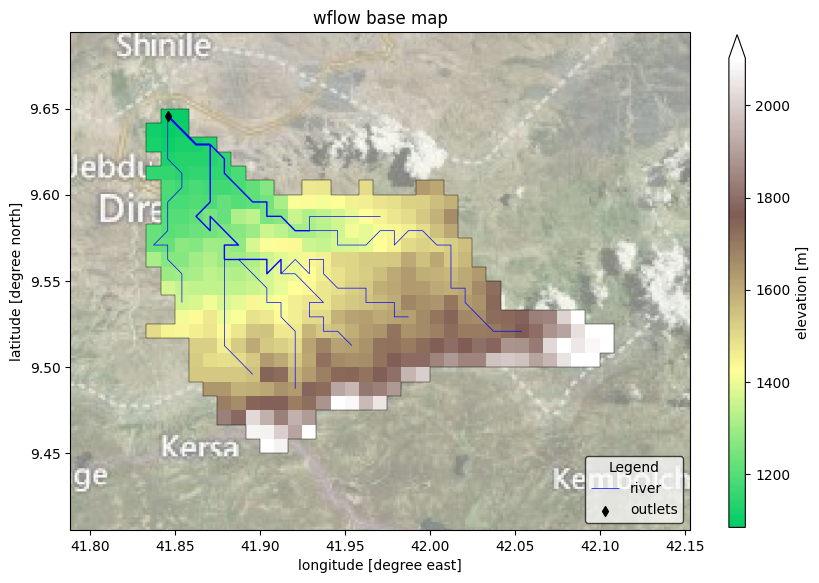

In [11]:
# read and mask the model elevation
da = model.staticmaps.data["land_elevation"].raster.mask_nodata()
da.attrs.update(long_name="elevation", units="m")
# read/derive river geometries
gdf_riv = model.rivers
# read/derive model basin boundary
gdf_bas = model.basins

# we assume the model maps are in the geographic CRS EPSG:4326
proj = ccrs.PlateCarree()
# adjust zoomlevel and figure size to your basis size & aspect
zoom_level = 10
figsize = (10, 8)
shaded = False  # shaded elevation (looks nicer with more pixels (e.g.: larger basins))!

# initialize image with geoaxes
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(projection=proj)
bbox = da.raster.box.to_crs(3857).buffer(5e3).to_crs(da.raster.crs).total_bounds
extent = np.array(bbox)[[0, 2, 1, 3]]
ax.set_extent(extent, crs=proj)

# add sat background image
ax.add_image(cimgt.QuadtreeTiles(), zoom_level, alpha=0.5)

## plot elevation\
# create nice colormap
vmin, vmax = da.quantile([0.0, 0.98]).compute()
c_dem = plt.cm.terrain(np.linspace(0.25, 1, 256))
cmap = colors.LinearSegmentedColormap.from_list("dem", c_dem)
norm = colors.Normalize(vmin=vmin, vmax=vmax)
kwargs = dict(cmap=cmap, norm=norm)
# plot 'normal' elevation
da.plot(
    transform=proj, ax=ax, zorder=1, cbar_kwargs=dict(aspect=30, shrink=0.8), **kwargs
)
# plot elevation with shades
if shaded:
    ls = colors.LightSource(azdeg=315, altdeg=45)
    dx, dy = da.raster.res
    _rgb = ls.shade(
        da.fillna(0).values,
        norm=kwargs["norm"],
        cmap=kwargs["cmap"],
        blend_mode="soft",
        dx=dx,
        dy=dy,
        vert_exag=200,
    )
    rgb = xr.DataArray(dims=("y", "x", "rgb"), data=_rgb, coords=da.raster.coords)
    rgb = xr.where(np.isnan(da), np.nan, rgb)
    rgb.plot.imshow(transform=proj, ax=ax, zorder=2)

# plot rivers with increasing width with stream order
gdf_riv.plot(
    ax=ax, linewidth=gdf_riv["strord"] / 2, color="blue", zorder=3, label="river"
)
# plot the basin boundary
gdf_bas.boundary.plot(ax=ax, color="k", linewidth=0.3)
# plot various vector layers if present
if "outlets" in model.geoms.data:
    model.geoms.data["outlets"].plot(
        ax=ax, marker="d", markersize=25, facecolor="k", zorder=5, label="outlets"
    )
patches = []  # manual patches for legend, see https://github.com/geopandas/geopandas/issues/660
if "meta_reservoirs_no_control" in model.geoms.data:
    kwargs = dict(facecolor="lightblue", edgecolor="black", linewidth=1, label="reservoirs (natural lakes)")
    model.geoms.data["meta_reservoirs_no_control"].plot(ax=ax, zorder=4, **kwargs)
    patches.append(mpatches.Patch(**kwargs))
if "meta_reservoirs_simple_control" in model.geoms.data:
    kwargs = dict(facecolor="blue", edgecolor="black", linewidth=1, label="reservoirs (simple control)")
    model.geoms.data["meta_reservoirs_simple_control"].plot(ax=ax, zorder=4, **kwargs)
    patches.append(mpatches.Patch(**kwargs))
if "glaciers" in model.geoms.data:
    kwargs = dict(facecolor="grey", edgecolor="grey", linewidth=1, label="glaciers")
    model.geoms.data["glaciers"].plot(ax=ax, zorder=4, **kwargs)
    patches.append(mpatches.Patch(**kwargs))

ax.xaxis.set_visible(True)
ax.yaxis.set_visible(True)
ax.set_ylabel(f"latitude [degree north]")
ax.set_xlabel(f"longitude [degree east]")
_ = ax.set_title(f"wflow base map")
legend = ax.legend(
    handles=[*ax.get_legend_handles_labels()[0], *patches],
    title="Legend",
    loc="lower right",
    frameon=True,
    framealpha=0.7,
    edgecolor="k",
    facecolor="white",
)

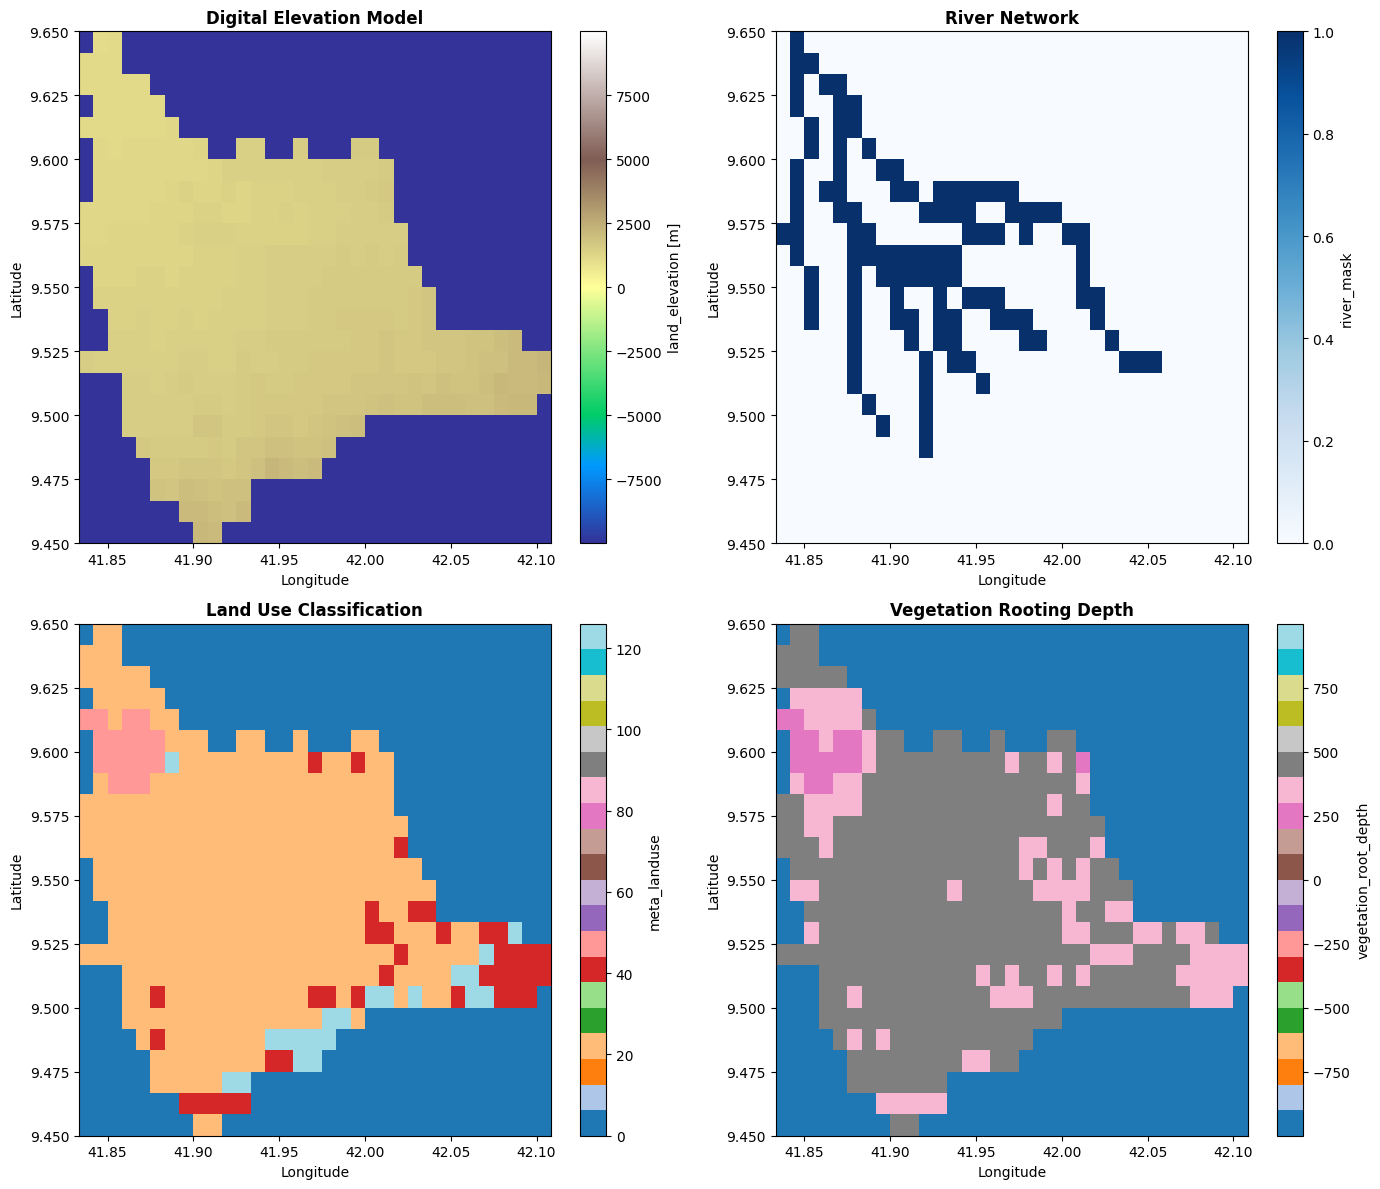

In [12]:
# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Elevation
model.staticmaps.data['land_elevation'].plot(ax=axes[0, 0], cmap='terrain')
axes[0, 0].set_title('Digital Elevation Model', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Longitude')
axes[0, 0].set_ylabel('Latitude')

# Plot 2: River network
model.staticmaps.data['river_mask'].plot(ax=axes[0, 1], cmap='Blues')
axes[0, 1].set_title('River Network', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Longitude')
axes[0, 1].set_ylabel('Latitude')

# Plot 3: Land use
model.staticmaps.data['meta_landuse'].plot(ax=axes[1, 0], cmap='tab20')
axes[1, 0].set_title('Land Use Classification', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Longitude')
axes[1, 0].set_ylabel('Latitude')

# Plot 4: Land slope
model.staticmaps.data['vegetation_root_depth'].plot(ax=axes[1, 1], cmap='tab20')
axes[1, 1].set_title('Vegetation Rooting Depth', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Longitude')
axes[1, 1].set_ylabel('Latitude')

plt.tight_layout()
plt.show()

### Fix missing data if present

In [20]:
from pathlib import Path

# Direct fix for your model
model_name = selected_coords.get('model_name')
staticmaps_path = Path(f"./wflow_models/{model_name}/staticmaps.nc")

print(f"Fixing: {staticmaps_path}")

# Open dataset
ds = xr.open_dataset(staticmaps_path)

# List of variables that might have missing values
soil_vars = [
    'soil_ksat_vertical',
    'soil_theta_s', 
    'soil_theta_r',
    'soil_brooks_corey_c',
    'soil_f',
    'soil_thickness'
]

# Check and fix each variable
for var in soil_vars:
    if var in ds:
        n_missing = ds[var].isnull().sum().values
        if n_missing > 0:
            print(f"  {var}: {n_missing} missing values - FIXING")
            # Fill with median of non-missing values
            fill_value = float(ds[var].median(skipna=True).values)
            if np.isnan(fill_value):
                fill_value = 10.0  # fallback
            ds[var] = ds[var].fillna(fill_value)
        else:
            print(f"  {var}: OK")

# Save fixed version
print("\nSaving fixed staticmaps...")
ds.to_netcdf(staticmaps_path.parent / "staticmaps_fixed.nc")
ds.close()

# Replace original
import shutil
shutil.copy2(staticmaps_path, staticmaps_path.parent / "staticmaps_backup.nc")
shutil.move(staticmaps_path.parent / "staticmaps_fixed.nc", staticmaps_path)

print(f"✓ Fixed staticmaps saved")
print(f"✓ Backup at: {staticmaps_path.parent / 'staticmaps_backup.nc'}")

Fixing: wflow_models/test/staticmaps.nc
  soil_ksat_vertical: 792 missing values - FIXING
  soil_theta_s: 399 missing values - FIXING
  soil_theta_r: 399 missing values - FIXING
  soil_brooks_corey_c: 3168 missing values - FIXING
  soil_f: 792 missing values - FIXING
  soil_thickness: 399 missing values - FIXING

Saving fixed staticmaps...
✓ Fixed staticmaps saved
✓ Backup at: wflow_models/test/staticmaps_backup.nc


---

## Part 5: Running the Model

### 5.1 Execute the Wflow Simulation

Now that the model is built and configured, we can run the simulation. Wflow uses the Julia-based Wflow.jl backend for efficient computation.

In [34]:
model_name = selected_coords['model_name']
!julia -e 'using Wflow; Wflow.run("./wflow_models/{model_name}/wflow_sbm.toml")'

[ Info: Wflow version v1.0.0-dev
[ Info: Initialize model variables for model type sbm.
[ Info: Cyclic parameters are provided by wflow_models/test/staticmaps.nc.
[ Info: Forcing parameters are provided by wflow_models/test/inmaps.nc.
┌ Info: Set atmosphere_water__precipitation_volume_flux using netCDF variable
└ precip as forcing parameter.
┌ Info: Set atmosphere_air__temperature using netCDF variable temp as forcing
└ parameter.
┌ Info: Set land_surface_water__potential_evaporation_volume_flux using
└ netCDF variable pet as forcing parameter.
┌ Info: Set vegetation__leaf_area_index using netCDF variable
└ vegetation_leaf_area_index as cyclic parameter, with 12 timesteps.
┌ Info: General model settings
│   snow = true
│   gravitational_snow_transport = true
│   glacier = false
│   reservoirs = false
│   pits = false
└   water_demand = false
[ Info: Set subbasin_location__count using netCDF variable subcatchment.
┌ Info: Set basin__local_drain_direction using netCDF variable
└ local_dr

**What happens during the run?**

1. **Initialization**: Model reads configuration and loads static maps
2. **State loading**: Initial conditions are loaded from `inmaps/`
3. **Time loop**: For each timestep:
   - Read forcing data (precipitation, temperature, PET)
   - Compute interception and snow processes
   - Calculate soil moisture dynamics
   - Simulate runoff generation
   - Route water through river network
   - Write outputs at specified frequency
4. **Finalization**: Save final state for future runs

**Runtime**: Depending on:
- Simulation period length
- Grid resolution and catchment size
- Time step (daily, hourly, etc.)
- Computer specifications

Expect 1-30 minutes for typical daily simulations of 1-5 years.

### 6.2 Monitoring Model Progress

During the run, watch for:
- **Water balance errors**: Should be < 0.1% per timestep
- **Convergence issues**: Indicates potential parameter problems
- **Memory usage**: Large models may need optimization
- **Progress updates**: Shows current date being simulated

---

## Part 7: Analyzing Model Results

### 7.1 Load and Inspect Output Files

In [35]:
# Load model outputs
model_name = selected_coords.get('model_name')
output_file = f"./wflow_models/{model_name}/run_default/output.nc"
ds = xr.open_dataset(output_file)

# Display dataset information
print("Output dataset contents:")
print(ds)
print("\nTime range:")
print(f"Start: {ds.time[0].values}")
print(f"End: {ds.time[-1].values}")
print(f"Total timesteps: {len(ds.time)}")

Output dataset contents:
<xarray.Dataset> Size: 99kB
Dimensions:  (time: 31, lat: 24, lon: 33, layer: 4)
Coordinates:
  * time     (time) datetime64[ns] 248B 2020-01-02 2020-01-03 ... 2020-02-01
  * lat      (lat) float64 192B 9.454 9.463 9.471 9.479 ... 9.629 9.638 9.646
  * lon      (lon) float64 264B 41.84 41.85 41.85 41.86 ... 42.09 42.1 42.1
  * layer    (layer) float64 32B 1.0 2.0 3.0 4.0
Data variables:
    q_av     (time, lat, lon) float32 98kB ...

Time range:
Start: 2020-01-02T00:00:00.000000000
End: 2020-02-01T00:00:00.000000000
Total timesteps: 31


### 7.2 Visualize Discharge Time Series

Let's plot the simulated discharge at the basin outlet:

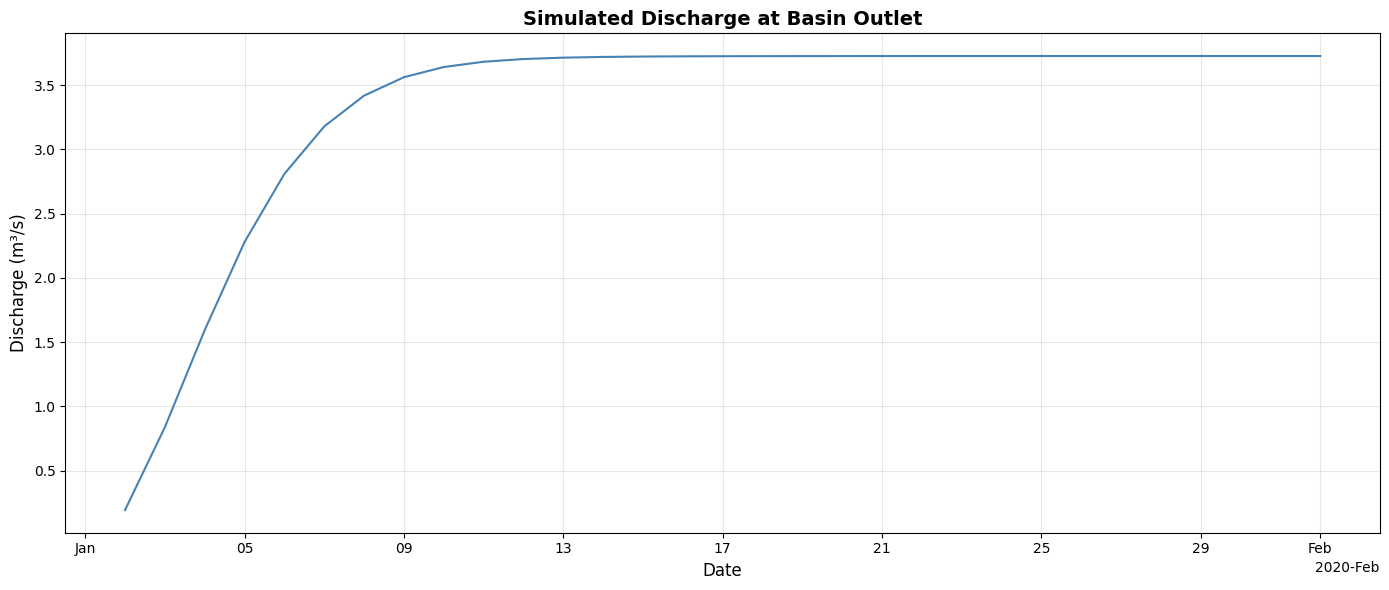

In [36]:
# Extract discharge at the outlet

# Get outlet location (typically where river has maximum upstream area)
discharge = ds['q_av'].max(dim=['lon', 'lat'])  # Adjust dimensions as needed

# Create discharge plot
fig, ax = plt.subplots(figsize=(14, 6))
discharge.plot(ax=ax, linewidth=1.5, color='steelblue')
ax.set_title('Simulated Discharge at Basin Outlet', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Discharge (m³/s)', fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 7.3 Spatial Visualization of Model Results

Create spatial maps of outputs:

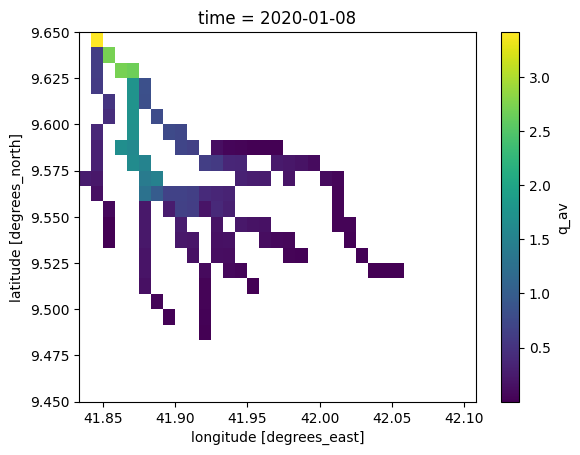

In [37]:
ds['q_av'].isel(time=6).plot()

---

## Part 8: Best Practices and Troubleshooting

### 8.1 Common Issues and Solutions

**Problem**: Model build fails with "No data found for region"
- **Solution**: Check your region coordinates are correct (lon, lat order)
- Verify data catalog has coverage for your area
- Try a slightly larger bounding box

**Problem**: Very high or low discharge values
- **Solution**: Check forcing data units (mm/day vs mm/hour)
- Verify DEM and river network are realistic
- Inspect parameter maps for outliers

**Problem**: Model runs slowly
- **Solution**: Reduce grid resolution in build configuration
- Use coarser timestep if appropriate
- Limit output variables to essentials

**Problem**: Large water balance errors
- **Solution**: Check for missing or corrupted forcing data
- Verify static maps have no missing values
- Review numerical stability settings

### 8.2 Quality Control Checklist

Before running your model, verify:
- ✓ DEM has no sinks or anomalies
- ✓ River network matches expected topology
- ✓ Land use classes are reasonable
- ✓ Soil parameters within physical ranges
- ✓ Forcing data covers simulation period
- ✓ No missing values in critical maps
- ✓ Output directory has write permissions

### 8.3 Performance Optimization Tips

1. **Grid resolution**: Start coarse (500m-1km), refine if needed
2. **Timestep**: Use daily timestep unless sub-daily processes are critical
3. **Output frequency**: Write only what you need for analysis
4. **Spatial extent**: Model only the catchment of interest
5. **Warmup period**: Use 1-2 years to initialize states properly

---

## Summary and Next Steps

### What We've Learned

In this tutorial, you've learned the complete workflow for building and running your first Wflow model:
1. ✓ Set up and verify HydroMT installation
2. ✓ Build a complete Wflow model from scratch using example data
3. ✓ Visualize model components (topography, rivers, land use)
4. ✓ Understand model structure and key files
5. ✓ Run hydrological simulations
6. ✓ Analyze and visualize model outputs

### Additional Resources

**Documentation**:
- HydroMT docs: https://deltares.github.io/hydromt/
- HydroMT-Wflow plugin: https://deltares.github.io/hydromt_wflow/
- Wflow documentation: https://deltares.github.io/Wflow.jl/

**Community**:
- GitHub discussions: https://github.com/Deltares/hydromt/discussions
- Issue tracker: https://github.com/Deltares/hydromt_wflow/issues

---